<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [169]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem

import scipy.stats as stats
import statsmodels.stats.api as sms

import pylab as plt
import seaborn as sns

from bayes import *

In [140]:
# datos
cookie=pd.read_csv('data/cookie_cats.csv')

cookie


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [141]:
# transformacion
gate_30=cookie[cookie.version=='gate_30']

gate_40=cookie[cookie.version=='gate_40']

len(gate_30), len(gate_40)

(44700, 45489)

In [142]:
# muestreo

control=gate_30

tratamiento=gate_40

ab_test=pd.concat([control, tratamiento], axis=0)

ab_test.reset_index(drop=True, inplace=True)

ab_test.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,1066,gate_30,0,False,False
3,2101,gate_30,0,False,False
4,2179,gate_30,39,True,False


In [143]:
# testeo para retention_1
tasas_conversion=ab_test.groupby('version')['retention_1']  # agrupo por grupo



std=lambda x: np.std(x, ddof=0)    # std
error_std=lambda x: stats.sem(x, ddof=0)   # error standard , (std/sqrt(n))



tasas_conversion=tasas_conversion.agg([np.mean, std, error_std])
tasas_conversion.columns=['conversion_rate', 'std', 'std_error']

tasas_conversion.style.format('{:.3f}')


,conversion_rate,std,std_error
version,,,
gate_30,0.448,0.497,0.002
gate_40,0.442,0.497,0.002


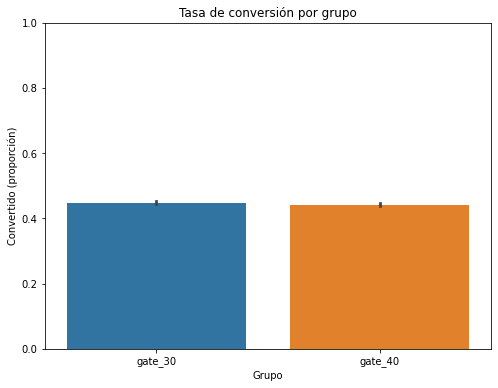

In [144]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['version'], 
            y=ab_test['retention_1'])

plt.ylim(0, 1)
plt.title('Tasa de conversión por grupo')
plt.xlabel('Grupo')
plt.ylabel('Convertido (proporción)');

In [145]:
# testeo para retention_7

tasas_conversion=ab_test.groupby('version')['retention_7']  # agrupo por grupo



std=lambda x: np.std(x, ddof=0)    # std
error_std=lambda x: stats.sem(x, ddof=0)   # error standard , (std/sqrt(n))



tasas_conversion=tasas_conversion.agg([np.mean, std, error_std])
tasas_conversion.columns=['conversion_rate', 'std', 'std_error']


tasas_conversion.style.format('{:.3f}')

,conversion_rate,std,std_error
version,,,
gate_30,0.190,0.392,0.002
gate_40,0.182,0.386,0.002


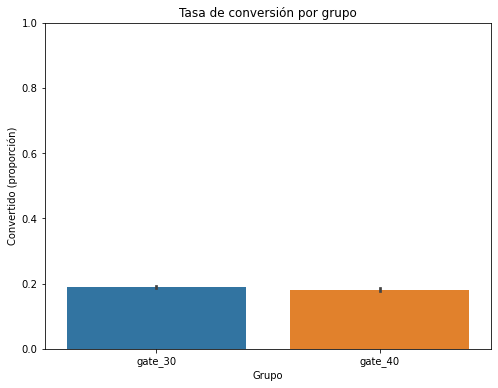

In [146]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['version'], 
            y=ab_test['retention_7'])

plt.ylim(0, 1)
plt.title('Tasa de conversión por grupo')
plt.xlabel('Grupo')
plt.ylabel('Convertido (proporción)');

In [147]:
control_res=ab_test[ab_test.version=='gate_30']['retention_1']

trat_res=ab_test[ab_test.version=='gate_40']['retention_1']

observaciones=44700+ 45489  # count



conversiones=[control_res.sum(), trat_res.sum()]  # conversiones por grupo


z_score, p_valor = proportions_ztest(conversiones, nobs=observaciones)

(control_a, trata_a), (control_b, trata_b) = proportion_confint(conversiones, 
                                                                nobs=observaciones,
                                                                alpha=0.05)

print(f'z-score: {z_score:.2f}')
print(f'p-valor: {p_valor:.3f}')
print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')
print(f'intervalo conf 95% para grupo tratamiento: [{trata_a:.3f}, {trata_b:.3f}]')

z-score: -0.48
p-valor: 0.630
intervalo conf 95% para grupo control: [0.219, 0.225]
intervalo conf 95% para grupo tratamiento: [0.220, 0.226]


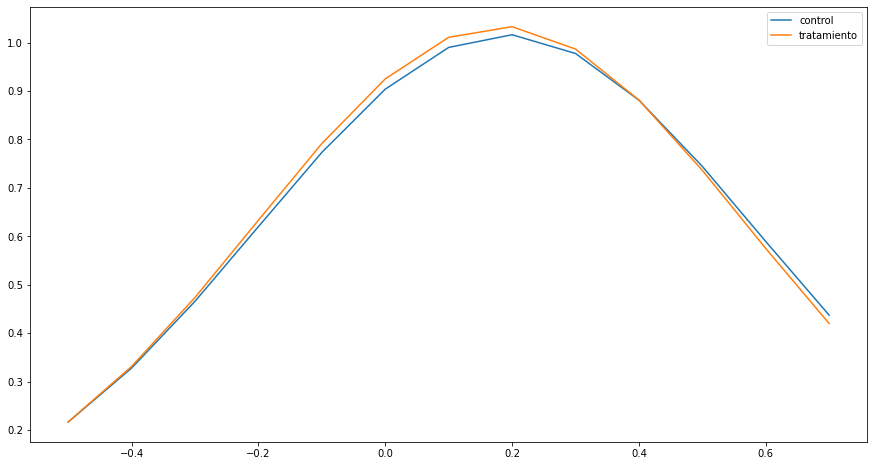

In [148]:
x=[i*.1 for i in range(-5, 8)]  

control=[norm.pdf(x, tasas_conversion.iloc[0][0], tasas_conversion.iloc[0][1]) for x in x] 

tratamiento=[norm.pdf(x, tasas_conversion.iloc[1][0], tasas_conversion.iloc[1][1]) for x in x] 

plt.plot(x, control)
plt.plot(x, tratamiento)
plt.legend(['control', 'tratamiento']);

In [149]:
control_res=ab_test[ab_test.version=='gate_30']['retention_7']

trat_res=ab_test[ab_test.version=='gate_40']['retention_7']

observaciones=44700+45489  # count

conversiones=[control_res.sum(), trat_res.sum()]  # conversiones por grupo


z_score, p_valor = proportions_ztest(conversiones, nobs=observaciones)

(control_a, trata_a), (control_b, trata_b) = proportion_confint(conversiones, 
                                                                nobs=observaciones,
                                                                alpha=0.05)

print(f'z-score: {z_score:.2f}')
print(f'p-valor: {p_valor:.3f}')
print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')
print(f'intervalo conf 95% para grupo tratamiento: [{trata_a:.3f}, {trata_b:.3f}]')

z-score: 1.81
p-valor: 0.071
intervalo conf 95% para grupo control: [0.092, 0.096]
intervalo conf 95% para grupo tratamiento: [0.090, 0.094]


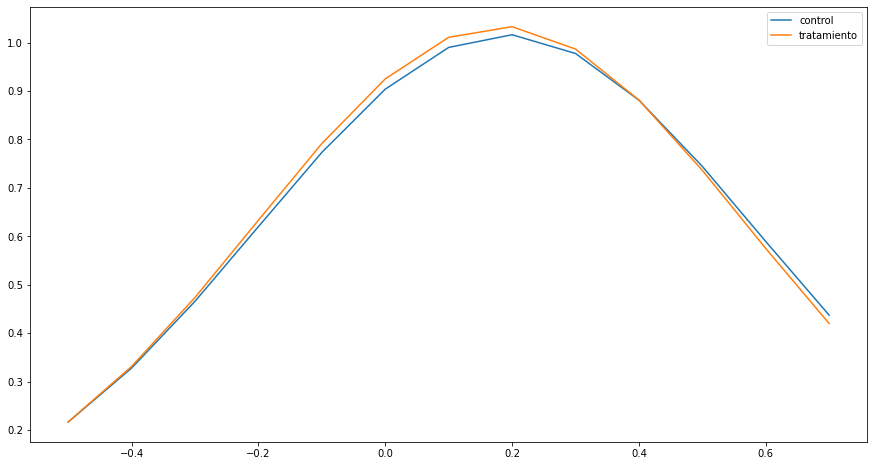

In [150]:
x=[i*.1 for i in range(-5, 8)]  

control=[norm.pdf(x, tasas_conversion.iloc[0][0], tasas_conversion.iloc[0][1]) for x in x] 

tratamiento=[norm.pdf(x, tasas_conversion.iloc[1][0], tasas_conversion.iloc[1][1]) for x in x] 

plt.plot(x, control)
plt.plot(x, tratamiento)
plt.legend(['control', 'tratamiento']);

In [151]:
# conclusiones
# H0  no se puede rechazar en ningún caso

#BAYES

In [152]:
import warnings
warnings.simplefilter('ignore')


import numpy as np
import pylab as plt
plt.rcParams['figure.figsize']=(15, 8)

from scipy.stats import bernoulli, beta  

In [153]:
gate_301=cookie[(cookie.version=='gate_30')  & (cookie.retention_1==True)]

gate_401=cookie[(cookie.version=='gate_40') & (cookie.retention_1==True) ]

len(gate_301), len(gate_401)

(20034, 20119)

In [154]:
gate_301=cookie[(cookie.version=='gate_30')  & (cookie.retention_7==True)]

gate_401=cookie[(cookie.version=='gate_40') & (cookie.retention_7==True) ]

len(gate_301), len(gate_401)

(8502, 8279)

In [155]:
imps_ctrl, convs_ctrl = 44700, 20034   # usuarios, comprar
imps_test, convs_test= 45489, 20119


CR_ctrl = convs_ctrl/imps_ctrl
CR_test = convs_test/imps_test

f'TASAS: Control={CR_ctrl}, Test={CR_test}'

'TASAS: Control=0.4481879194630872, Test=0.44228274967574577'

In [156]:
a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1
a_T, b_T = convs_test+1, imps_test-convs_test+1

beta_control=beta(a_C, b_C)
beta_test=beta(a_T, b_T)

In [157]:
beta_control.mean(), beta_test.mean()

(0.44819023757326293, 0.44228528719966587)

In [170]:
x=np.linspace(0.43, 0.47, 1000)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

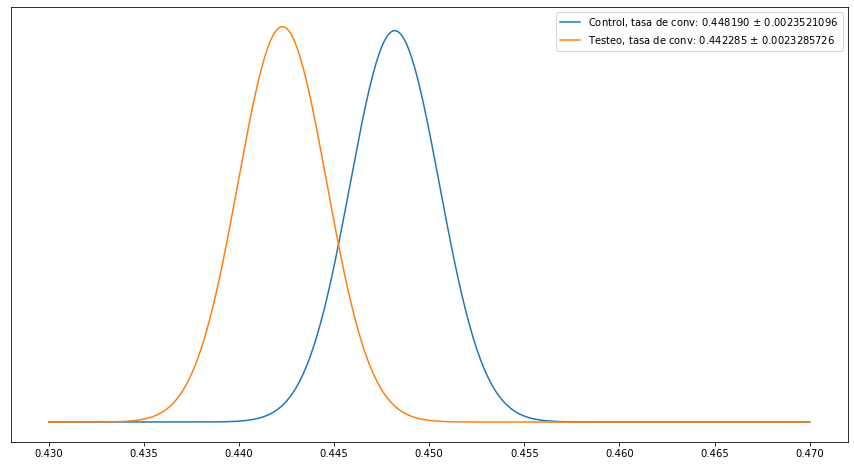

In [171]:
plot([beta_control, beta_test], ['Control', 'Testeo'])

In [172]:
from mpmath import betainc 

salto=(beta_test.mean() - beta_control.mean())/beta_control.mean()


prob=1- beta_control.cdf(0.445)

prob=float(prob)

'''El test aumenta la tasa de conversion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto*100, prob*100)

'El test aumenta la tasa de conversion en un -1.32%, con una probabilidad del 91.25%'

In [ ]:
imps_ctrl, convs_ctrl = 44700, 8502   # usuarios, comprar
imps_test, convs_test= 45489, 8279


CR_ctrl = convs_ctrl/imps_ctrl
CR_test = convs_test/imps_test

f'TASAS: Control={CR_ctrl}, Test={CR_test}'

'TASAS: Control=0.19020134228187918, Test=0.18200004396667327'

In [ ]:
a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1
a_T, b_T = convs_test+1, imps_test-convs_test+1

beta_control=beta(a_C, b_C)
beta_test=beta(a_T, b_T)

beta_control.mean(), beta_test.mean()

(0.19021520289919913, 0.18201402475214878)

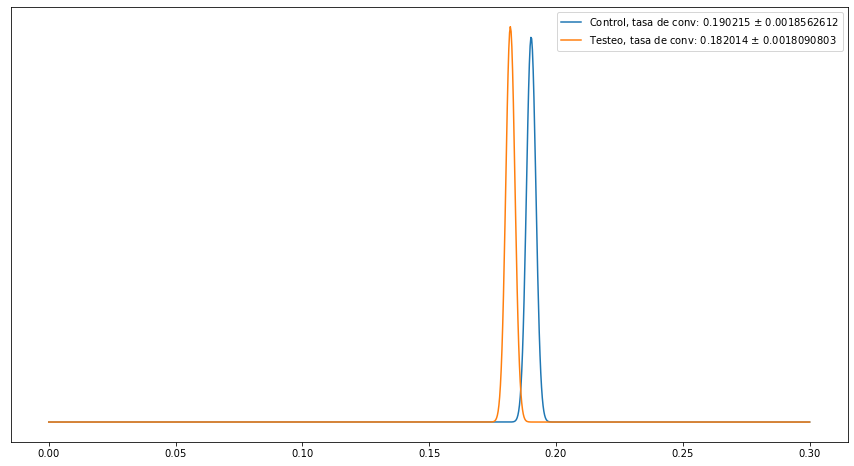

In [ ]:
x=np.linspace(0, 0.3, 1000)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();
    
plot([beta_control, beta_test], ['Control', 'Testeo'])

In [173]:
salto=(beta_test.mean() - beta_control.mean())/beta_control.mean()


prob=beta_control.cdf(0.18)

prob=float(prob)

'''El test aumenta la tasa de conversion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto*100, prob*100)

'El test aumenta la tasa de conversion en un -1.32%, con una probabilidad del 0.00%'